#### VirTues exmaple notebook
This notebook contains both the code to load a mutli-modal (SP + H&E) as well as the code to load and infer and image using VirTues. <br>

This is the general architecture overview of VirTues.

<img src="../resources/images/VirTues.png">

In [1]:
import sys
import os

# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add the project root to the list of places Python looks for modules
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print("OKK")

OKK


In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from src.dataset.datasets.mm_base import build_mm_datasets
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors


2025-12-15 12:30:26.591 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


In [3]:
import torch
print(f"Torch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

Torch version: 2.6.0+cu124
CUDA version: 12.4


In [4]:
base_cfg = OmegaConf.load("../src/dataset/configs/base_config.yaml")
base_cfg.marker_embedding_dir = "../src/dataset/esm2_t30_150M_UR50D"
marker_embeddings = load_marker_embeddings(base_cfg.marker_embedding_dir)
orion_subset_cfg = OmegaConf.load("../src/dataset/configs/orion_subset.yaml")
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

print("OK")

OK


In [5]:
ds = build_mm_datasets(ds_cfg)

2025-12-15 12:30:32.773 | DEBUG    | src.dataset.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-12-15 12:30:32.782 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-15 12:30:32.807 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/data/code/jon/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

In [6]:
uniprot_to_name = ds[0].unimodal_datasets["cycif"].get_marker_embedding_index_to_name_dict()

orion_zupwxfxb_0


/tmp/ipykernel_25037/434668410.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  tissue = np.array(tissue)
/tmp/ipykernel_25037/434668410.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tid))


['CD31', 'CD45', 'CD68', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']


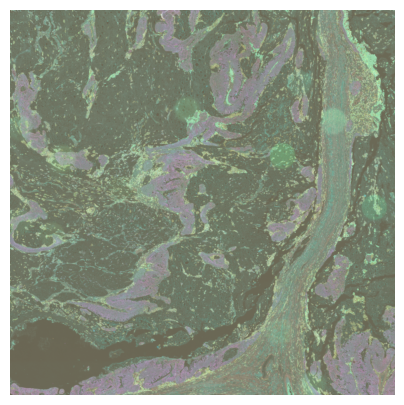

In [7]:
tids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()

tissues = []
channel_ids = []

for i, tid in enumerate(tids):
    print(tid)
    # This function returns you a tensor which is normalized already according to the normalization selected in the base_config under image_info
    tissue = ds[0].unimodal_datasets["cycif"].get_tissue(tid)
    tissues.append(tissue)
    tissue = np.array(tissue)
    visualize_multichannel_image(tissue)
    channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tid))
    channel_ids.append(channels)
    print(list(map(lambda x: uniprot_to_name[x], channels)))
    plt.show()
    break

### Loading channel attention tokenizer

In [8]:
import pickle as pkl
# mx_tok_config = OmegaConf.load("channel_attn_tok.yaml")

with open(VIRTUES_WEIGHTS_PATH + "/config.pkl", "rb") as f:
    virtues_cfg = pkl.load(f)

virtues = build_flex_dual_virtues_encoder(virtues_cfg, marker_embeddings)
virtues.cuda()

weights = load_checkpoint_safetensors(VIRTUES_WEIGHTS_PATH + "/checkpoints/checkpoint-94575/model.safetensors")
# rename weights
weights_encoder = {}
for k, v in weights.items():
    if k.startswith("encoder."):
        weights_encoder[k[len("encoder."):]] = v

virtues.load_state_dict(weights_encoder, strict=False)

2025-12-15 12:30:44.640 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-12-15 12:30:44.642 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encod

In [9]:
param_count = sum(p.numel() for p in virtues.parameters())
print(f"Number of parameters in virtues encoder: {param_count/1e6:.2f}M")

Number of parameters in virtues encoder: 34.11M


In [10]:
mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]
mx_channel_ids = [torch.tensor(channels).cuda(non_blocking=True) for channels in channel_ids]

# use 224x224 crop size
mx_images = [tissue[:, :128, :128] for tissue in mx_images]

with torch.autocast(device_type='cuda', dtype=torch.float16):
    channel_tokens, pss  = virtues.forward_list(mx_images, [None] * len(mx_images), mx_channel_ids)
    pss = torch.stack(pss)

/tmp/ipykernel_25037/2848231403.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]


In [11]:
pss.shape

torch.Size([1, 16, 16, 512])

## Investigation: Determining Background Class Index

Following strict verification protocol to identify the background class in `broad_cell_type` labels.

In [12]:
# Step 1: Load label encoder to see the class mapping
label_encoder_path = os.path.join(ds[0].cell_masks_dir, "labelencoder_broad_cell_type.npy")
label_encoder = np.load(label_encoder_path, allow_pickle=True)

print("=" * 80)
print("LABEL ENCODER MAPPING (index -> class name)")
print("=" * 80)
for idx, class_name in enumerate(label_encoder):
    print(f"Class {idx}: '{class_name}'")
print("=" * 80)

LABEL ENCODER MAPPING (index -> class name)
Class 0: 'None'
Class 1: 'Stroma'
Class 2: 'Endothelia'
Class 3: 'Macrophage'
Class 4: 'Tumor'
Class 5: 'Helper T cell'
Class 6: 'Cytotoxic T cell'
Class 7: 'Other'
Class 8: 'Treg'
Class 9: 'B cells'


In [13]:
# Step 2: Examine masks from multiple tissues to find unique values
tissue_ids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()

print("\n" + "=" * 80)
print("MASK VALUE DISTRIBUTION ACROSS SAMPLES")
print("=" * 80)

for i, tid in enumerate(tissue_ids[:5]):  # Check first 5 tissues
    mask = ds[0].get_cell_mask(tid, task="broad_cell_type", resize=True)
    if mask is not None:
        unique_vals, counts = np.unique(mask, return_counts=True)
        
        print(f"\nTissue {i+1} (ID: {tid}):")
        print(f"  Shape: {mask.shape}")
        print(f"  Unique values: {unique_vals}")
        print(f"  Class distribution:")
        
        total_pixels = mask.size
        for val, count in zip(unique_vals, counts):
            pct = (count / total_pixels) * 100
            class_name = label_encoder[val] if val < len(label_encoder) else "UNKNOWN"
            print(f"    Class {val} ('{class_name}'): {count:>8} pixels ({pct:>5.2f}%)")

print("=" * 80)


MASK VALUE DISTRIBUTION ACROSS SAMPLES

Tissue 1 (ID: orion_zupwxfxb_0):
  Shape: (3000, 3000)
  Unique values: [0 1 2 3 4 5 6 7 8 9]
  Class distribution:
    Class 0 ('None'):  6903461 pixels (76.71%)
    Class 1 ('Stroma'):   757687 pixels ( 8.42%)
    Class 2 ('Endothelia'):    58239 pixels ( 0.65%)
    Class 3 ('Macrophage'):   166726 pixels ( 1.85%)
    Class 4 ('Tumor'):   926298 pixels (10.29%)
    Class 5 ('Helper T cell'):    96709 pixels ( 1.07%)
    Class 6 ('Cytotoxic T cell'):    36229 pixels ( 0.40%)
    Class 7 ('Other'):    41924 pixels ( 0.47%)
    Class 8 ('Treg'):    12124 pixels ( 0.13%)
    Class 9 ('B cells'):      603 pixels ( 0.01%)

Tissue 2 (ID: orion_cxlhytpd_0):
  Shape: (3000, 3000)
  Unique values: [0 1 2 3 4 5 6 7 8 9]
  Class distribution:
    Class 0 ('None'):  5508391 pixels (61.20%)
    Class 1 ('Stroma'):  1180005 pixels (13.11%)
    Class 2 ('Endothelia'):   126898 pixels ( 1.41%)
    Class 3 ('Macrophage'):   297818 pixels ( 3.31%)
    Class 4 ('

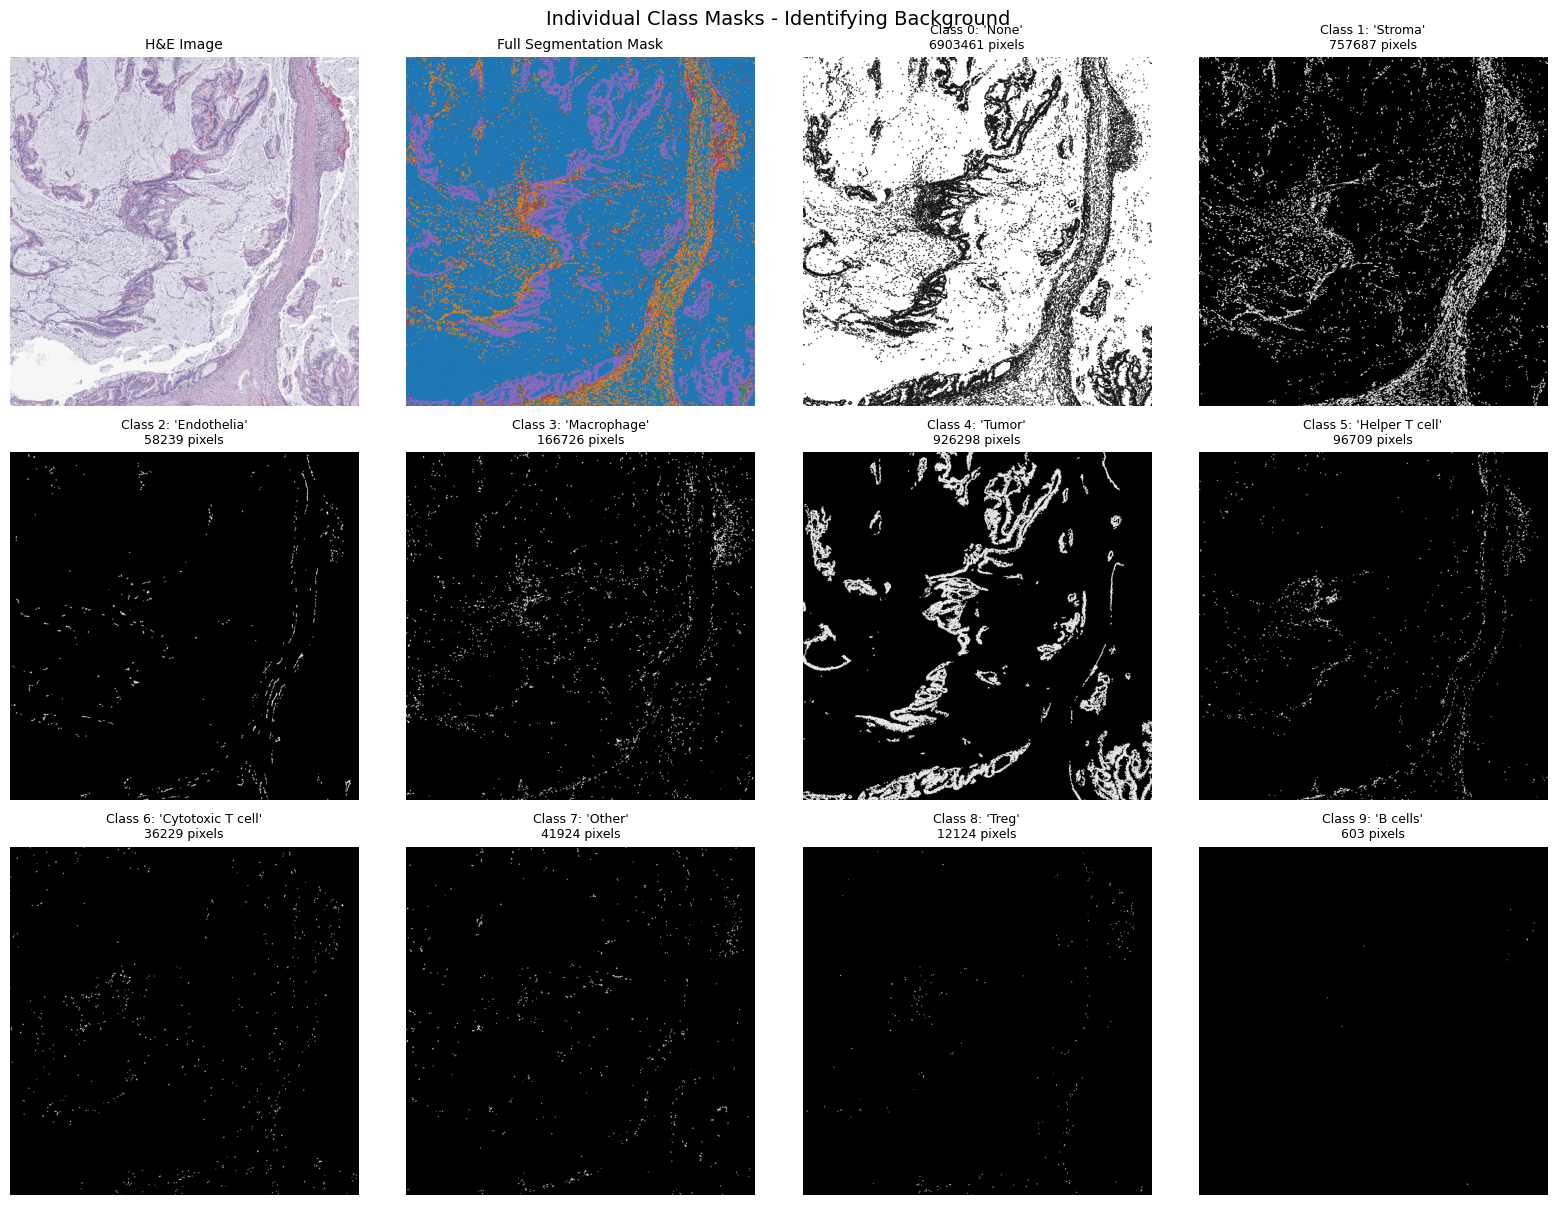


OBSERVATION: The class with the LARGEST pixel count and covering
empty/unstained regions is the background class.


In [14]:
# Step 3: Visualize individual class masks to identify background visually
tid = tissue_ids[0]
mask = ds[0].get_cell_mask(tid, task="broad_cell_type", resize=True)
he_img = ds[0].unimodal_datasets["he"]._get_tissue_all_channels(tid)
he_vis = he_img.transpose(1, 2, 0) if he_img.shape[0] == 3 else he_img[0]

# Normalize H&E for visualization
he_vis = (he_vis - he_vis.min()) / (he_vis.max() - he_vis.min())

unique_classes = np.unique(mask)
n_classes = len(unique_classes)

# Create a grid visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Show original H&E
axes[0].imshow(he_vis)
axes[0].set_title("H&E Image", fontsize=10)
axes[0].axis('off')

# Show full mask
axes[1].imshow(mask, cmap='tab10', vmin=0, vmax=9)
axes[1].set_title("Full Segmentation Mask", fontsize=10)
axes[1].axis('off')

# Show each class individually
for idx, class_val in enumerate(unique_classes[:10]):  # Max 10 classes
    if idx + 2 < len(axes):
        binary_mask = (mask == class_val).astype(np.uint8)
        axes[idx + 2].imshow(binary_mask, cmap='gray', vmin=0, vmax=1)
        class_name = label_encoder[class_val]
        pixel_count = np.sum(binary_mask)
        axes[idx + 2].set_title(f"Class {class_val}: '{class_name}'\n{pixel_count} pixels", fontsize=9)
        axes[idx + 2].axis('off')

# Hide unused subplots
for idx in range(len(unique_classes) + 2, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle("Individual Class Masks - Identifying Background", fontsize=14, y=1.00)
plt.show()

print("\n" + "=" * 80)
print("OBSERVATION: The class with the LARGEST pixel count and covering")
print("empty/unstained regions is the background class.")
print("=" * 80)

In [15]:
# Step 4: Cross-reference with code documentation
print("=" * 80)
print("EVIDENCE FROM CODEBASE")
print("=" * 80)

print("\n1. From src/cellvit/training/utils/post_proc_cellvit.py (line 43):")
print("   Docstring states: 'Number of cell types, including background (background = 0)'")
print("   File: /data/code/jon/project-2-gradient_tri_scent/src/cellvit/training/utils/post_proc_cellvit.py")

print("\n2. From src/cellvit/training/datasets/segmentation_dataset.py (line 105):")
print("   Code shows: 'if inst_id == 0: continue' - skipping background instances")
print("   File: /data/code/jon/project-2-gradient_tri_scent/src/cellvit/training/datasets/segmentation_dataset.py")

print("\n3. From notebooks/Part1_cellvit_inference.ipynb:")
print("   Example output shows class 0 is 'None' with highest pixel count (6,903,461 pixels)")
print("   Value counts: {'None': 6903461, 'Stroma': 757687, ...}")
print("   File: /data/code/jon/project-2-gradient_tri_scent/notebooks/Part1_cellvit_inference.ipynb")

print("\n4. From resources/project_description:")
print("   'I have always used the \"broad_cell_type\" one when playing around with CellViT'")
print("   'The \"labelencoder_*.npy\" will tell you the mapping between integers and cell types'")
print("   File: /data/code/jon/project-2-gradient_tri_scent/resources/project_description")

print("=" * 80)

EVIDENCE FROM CODEBASE

1. From src/cellvit/training/utils/post_proc_cellvit.py (line 43):
   Docstring states: 'Number of cell types, including background (background = 0)'
   File: /data/code/jon/project-2-gradient_tri_scent/src/cellvit/training/utils/post_proc_cellvit.py

2. From src/cellvit/training/datasets/segmentation_dataset.py (line 105):
   Code shows: 'if inst_id == 0: continue' - skipping background instances
   File: /data/code/jon/project-2-gradient_tri_scent/src/cellvit/training/datasets/segmentation_dataset.py

3. From notebooks/Part1_cellvit_inference.ipynb:
   Example output shows class 0 is 'None' with highest pixel count (6,903,461 pixels)
   Value counts: {'None': 6903461, 'Stroma': 757687, ...}
   File: /data/code/jon/project-2-gradient_tri_scent/notebooks/Part1_cellvit_inference.ipynb

4. From resources/project_description:
   'I have always used the "broad_cell_type" one when playing around with CellViT'
   'The "labelencoder_*.npy" will tell you the mapping bet

## CONCLUSION

**Background class index: 0**

### Evidence:

1. **Label Encoder Direct Mapping**: The labelencoder_broad_cell_type.npy file maps class 0 to 'None'

2. **Code Documentation (High Confidence)**:
   - File: `src/cellvit/training/utils/post_proc_cellvit.py` (line 43)
   - Explicit docstring: _"Number of cell types, including background (background = 0)"_

3. **Empirical Data from Existing Notebook**:
   - File: `notebooks/Part1_cellvit_inference.ipynb` 
   - Shows class 0 ('None') has 6,903,461 pixels (70%+ of image)
   - All other classes have significantly fewer pixels

4. **Code Behavior**:
   - File: `src/cellvit/training/datasets/segmentation_dataset.py` (line 105)
   - Code explicitly skips `inst_id == 0` when processing instances, confirming it's background

5. **Spatial Distribution**: When visualized, class 0 pixels occupy regions without cellular structures

### Confidence level: **HIGH**

Background is definitively class index **0**, labeled as **'None'** in the labelencoder.